<a href="https://colab.research.google.com/github/tomonari-masada/course-nlp2020/blob/master/11_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 標準使用ライブラリー
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import shutil
from icecream import ic
from tqdm import tqdm_notebook as tqdm 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 追記
import json
import datetime
import math
plt.style.use('dark_background')

# debug
#%pdb on

import pixiedust #%pixie_debugger

# tfがエラーはかないため
# tfがエラーはかないため
#import tensorflow as tf
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="5"
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)


Pixiedust database opened successfully


In [2]:
import pandas as pd
import re
import emoji
from wordcloud import WordCloud, STOPWORDS

df = pd.read_csv("./result0605.csv", engine='python')

type(df["description"])
docs = df["description"].to_list()

In [3]:
print(len(docs))

93794


### Neologdを使ってtokenizeする

In [6]:

import subprocess
import MeCab

def make_neologd_tagger():
    cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
    path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                               shell=True).communicate()[0]).decode('utf-8')
    m=MeCab.Tagger("-Ochasen -d "+str(path_neologd))
    return (m)


def neolog_prep_text( text, m):
    return_words = []

    
    splited_text = (re.split('[\t,]', line) for line in m.parse(text).split('\n'))
    for tmp_word in splited_text :
        if (tmp_word[0] in ('EOS', '', 't', 'ー') ):
           continue 
        if not re.match( '名詞' ,tmp_word[3]  ) or tmp_word[0] in emoji.UNICODE_EMOJI["en"]:
            continue
        else:
            return_words.append(tmp_word[0])

    return return_words


* tokenizationの実行

In [7]:
from tqdm import tqdm


m = make_neologd_tagger()

new_docs = list()
for doc in tqdm(docs):
  if str(doc) == "nan":
    continue
  tmp_words =  neolog_prep_text(str(doc), m)
  new_docs.append( tmp_words )
  

100%|██████████| 93794/93794 [00:23<00:00, 3987.45it/s]


* tokenizationの結果を確認

In [8]:
print(new_docs[5])

['過去', 'ジャパリカート', '動画', 'TSUMURI', 'KART', 'VRChat', 'ワリスノ', 'MK', '8', 'DX', '一位', 'りし', 'た人', '社会', '出て', '配信', 'https', 'co', 'FJoitl', '8', 'JHE', 'ヘッダ', '猫', '飼い主', 'smmmmm']


* 各文書を長い文字列で表しなおす（CountVectorizerを後で使うため）

In [9]:
corpus = [' '.join(doc) for doc in new_docs]

## 11-02 データ行列の作成
* LDAの場合、単に単語の出現頻度を重みとして各文書をベクトル化する。

### sklearnのCountVectorizerで疎行列化する

* 全文書の半分より多い文書に現れる単語は、高頻度語とみなして削除する。
* 30件未満の文書にしか現れない単語は、低頻度語とみなして削除する。

In [10]:
import os
import urllib.request
def download_stopwords(path):
    url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
    if os.path.exists(path):
        print('File already exists.')
    else:
        print('Downloading...')
        # Download the file from `url` and save it locally under `file_name`:
        urllib.request.urlretrieve(url, path)

def create_stopwords(file_path):
    stop_words = []
    for w in open(path, "r"):
        w = w.replace('\n','')
        if len(w) > 0:
          stop_words.append(w)
    return stop_words    

path = "stop_words.txt"
download_stopwords(path)
stop_words = create_stopwords(path)

File already exists.


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

MIN_DF = 30

vectorizer = CountVectorizer(max_df=0.5, min_df= MIN_DF, stop_words=stop_words)

X = vectorizer.fit_transform(corpus)

In [12]:
print(len(vectorizer.get_feature_names()))

5100


* 文書数と語彙サイズを変数にセット

In [13]:
n_samples, n_features = X.shape

### TF-IDFで各文書における単語の重みを計算する

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
Xtfidf = tfidf.fit_transform(X)

In [15]:
print(Xtfidf[0])

  (0, 4227)	0.603862693464167
  (0, 4148)	0.4706802938434637
  (0, 3490)	0.1847556021921528
  (0, 3414)	0.3341859275888348
  (0, 3402)	0.3582132311126841
  (0, 1747)	0.24047370992039763
  (0, 1109)	0.2860956441170824


In [16]:
Xtfidf.shape

(88481, 5100)

### LDAのインポート

In [22]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
from time import time
from matplotlib.backends.backend_pdf import PdfPages
import datetime
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

### トピックの重要語を取り出す関数の定義

In [18]:
def get_top_words(model, feature_names, n_top_words=30):
  top_features = list()
  weights = list()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features.append([feature_names[i] for i in top_features_ind])
    weights.append(topic[top_features_ind])
  return top_features, weights

# LDAでトピック抽出

### LDAによるトピック抽出の実行

In [19]:
def make_word_cloud(n_components, lda):
    top_words, weights = get_top_words(lda, vectorizer.get_feature_names())
    topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]
    FONT_PATH = "/usr/share/fonts/opentype/ipaexfont-mincho/ipaexm.ttf"
    cloud = WordCloud(stopwords=STOPWORDS,
                  font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

    tate = math.ceil(n_components / 2)
    fig, axes = plt.subplots(tate, 2, figsize=(32, 50), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):

        if i > len(topic_words)-1:
            break

        fig.add_subplot(ax)
        cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()

    pdf = PdfPages( 
        (datetime.datetime.now() + datetime.timedelta(hours=9) ) .strftime('%m%d_%H%M') + 'topic.pdf')


    fignums = plt.get_fignums()
    for fignum in fignums:
        plt.figure(fignum)
        pdf.savefig()

    pdf.close()



In [58]:
import logging
import pickle
import itertools

def lda_main (n_components, topic_word_prior,batch_size =1000 ,max_iter=30):

    folder_name = (datetime.datetime.now() + datetime.timedelta(hours=9) ) .strftime('%m%d_%H%M')

    # フォルダを作成
    os.mkdir("./"+folder_name)
    os.chdir("./"+folder_name)

    logger = logging.getLogger()
    fhandler = logging.FileHandler(filename='mylog.log', mode='a')
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fhandler.setFormatter(formatter)
    logger.addHandler(fhandler)
    logger.setLevel(logging.WARNING)
    
    
    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=max_iter,
                                    topic_word_prior=topic_word_prior, # トピック数の逆数が目安の0.01,0.02,0.05,0.1などなど試す
                                    learning_method='online',
                                    learning_offset=50,
                                    batch_size= batch_size,# 多くする
                                    # learning_decay : 2??

                                    mean_change_tol=1e-4,
                                    random_state=1,
                                    evaluate_every=1,
                                    verbose=1)
    print((f"Fitting LDA models with tf features, "
    f"n_samples={n_samples} and n_features={n_features}"))
    t0 = time()
    lda.fit(X)
    print(f"done in {time() - t0:0.3f}s.")
    # パラメータの比較はperplexity
    # ハイパーパラメータ調整を頑張る！（やってられない！といわない！！）
    
    
    coherance = metric_coherence_gensim(measure='c_v', 
#                         top_n=20, # これはデフォルトが20
                        topic_word_distrib=lda.components_, 
                        dtm=Xtfidf,  # tfidfの結果
                        vocab=np.array([x for x in vectorizer.vocabulary_.keys()]), 
                        texts=new_docs)
    
    
    results = {
            "perplexity" : lda.perplexity(X) ,
            "coherance": coherance,
        }

    logger.warning('MIN_DF:{0}'.format(MIN_DF) )
    logger.warning('params:n_components:{0}'.format(n_components)) 
    logger.warning('params:topic_word_prior:{0}'.format(topic_word_prior)) 
    logger.warning('params:batch_size:{0}'.format(batch_size)) 
    logger.warning('params:max_iter:{0}'.format(max_iter)) 
    logger.warning('perplexity:{0}'.format(results["perplexity"])) 
    logger.warning('coherance:{0}'.format(results["coherance"]) )

    make_word_cloud(n_components, lda)
    # pickle
    file_name = (datetime.datetime.now() + datetime.timedelta(hours=9) ) .strftime('%m%d_%H%M') + '_lda.pickle'
    with open(file_name, mode="wb") as f:
        pickle.dump(lda, f)
    
    
    os.chdir("../")
    return(results)
    

Fitting LDA models with tf features, n_samples=88481 and n_features=5100
iteration: 1 of max_iter: 1, perplexity: 1675.1924
done in 66.403s.


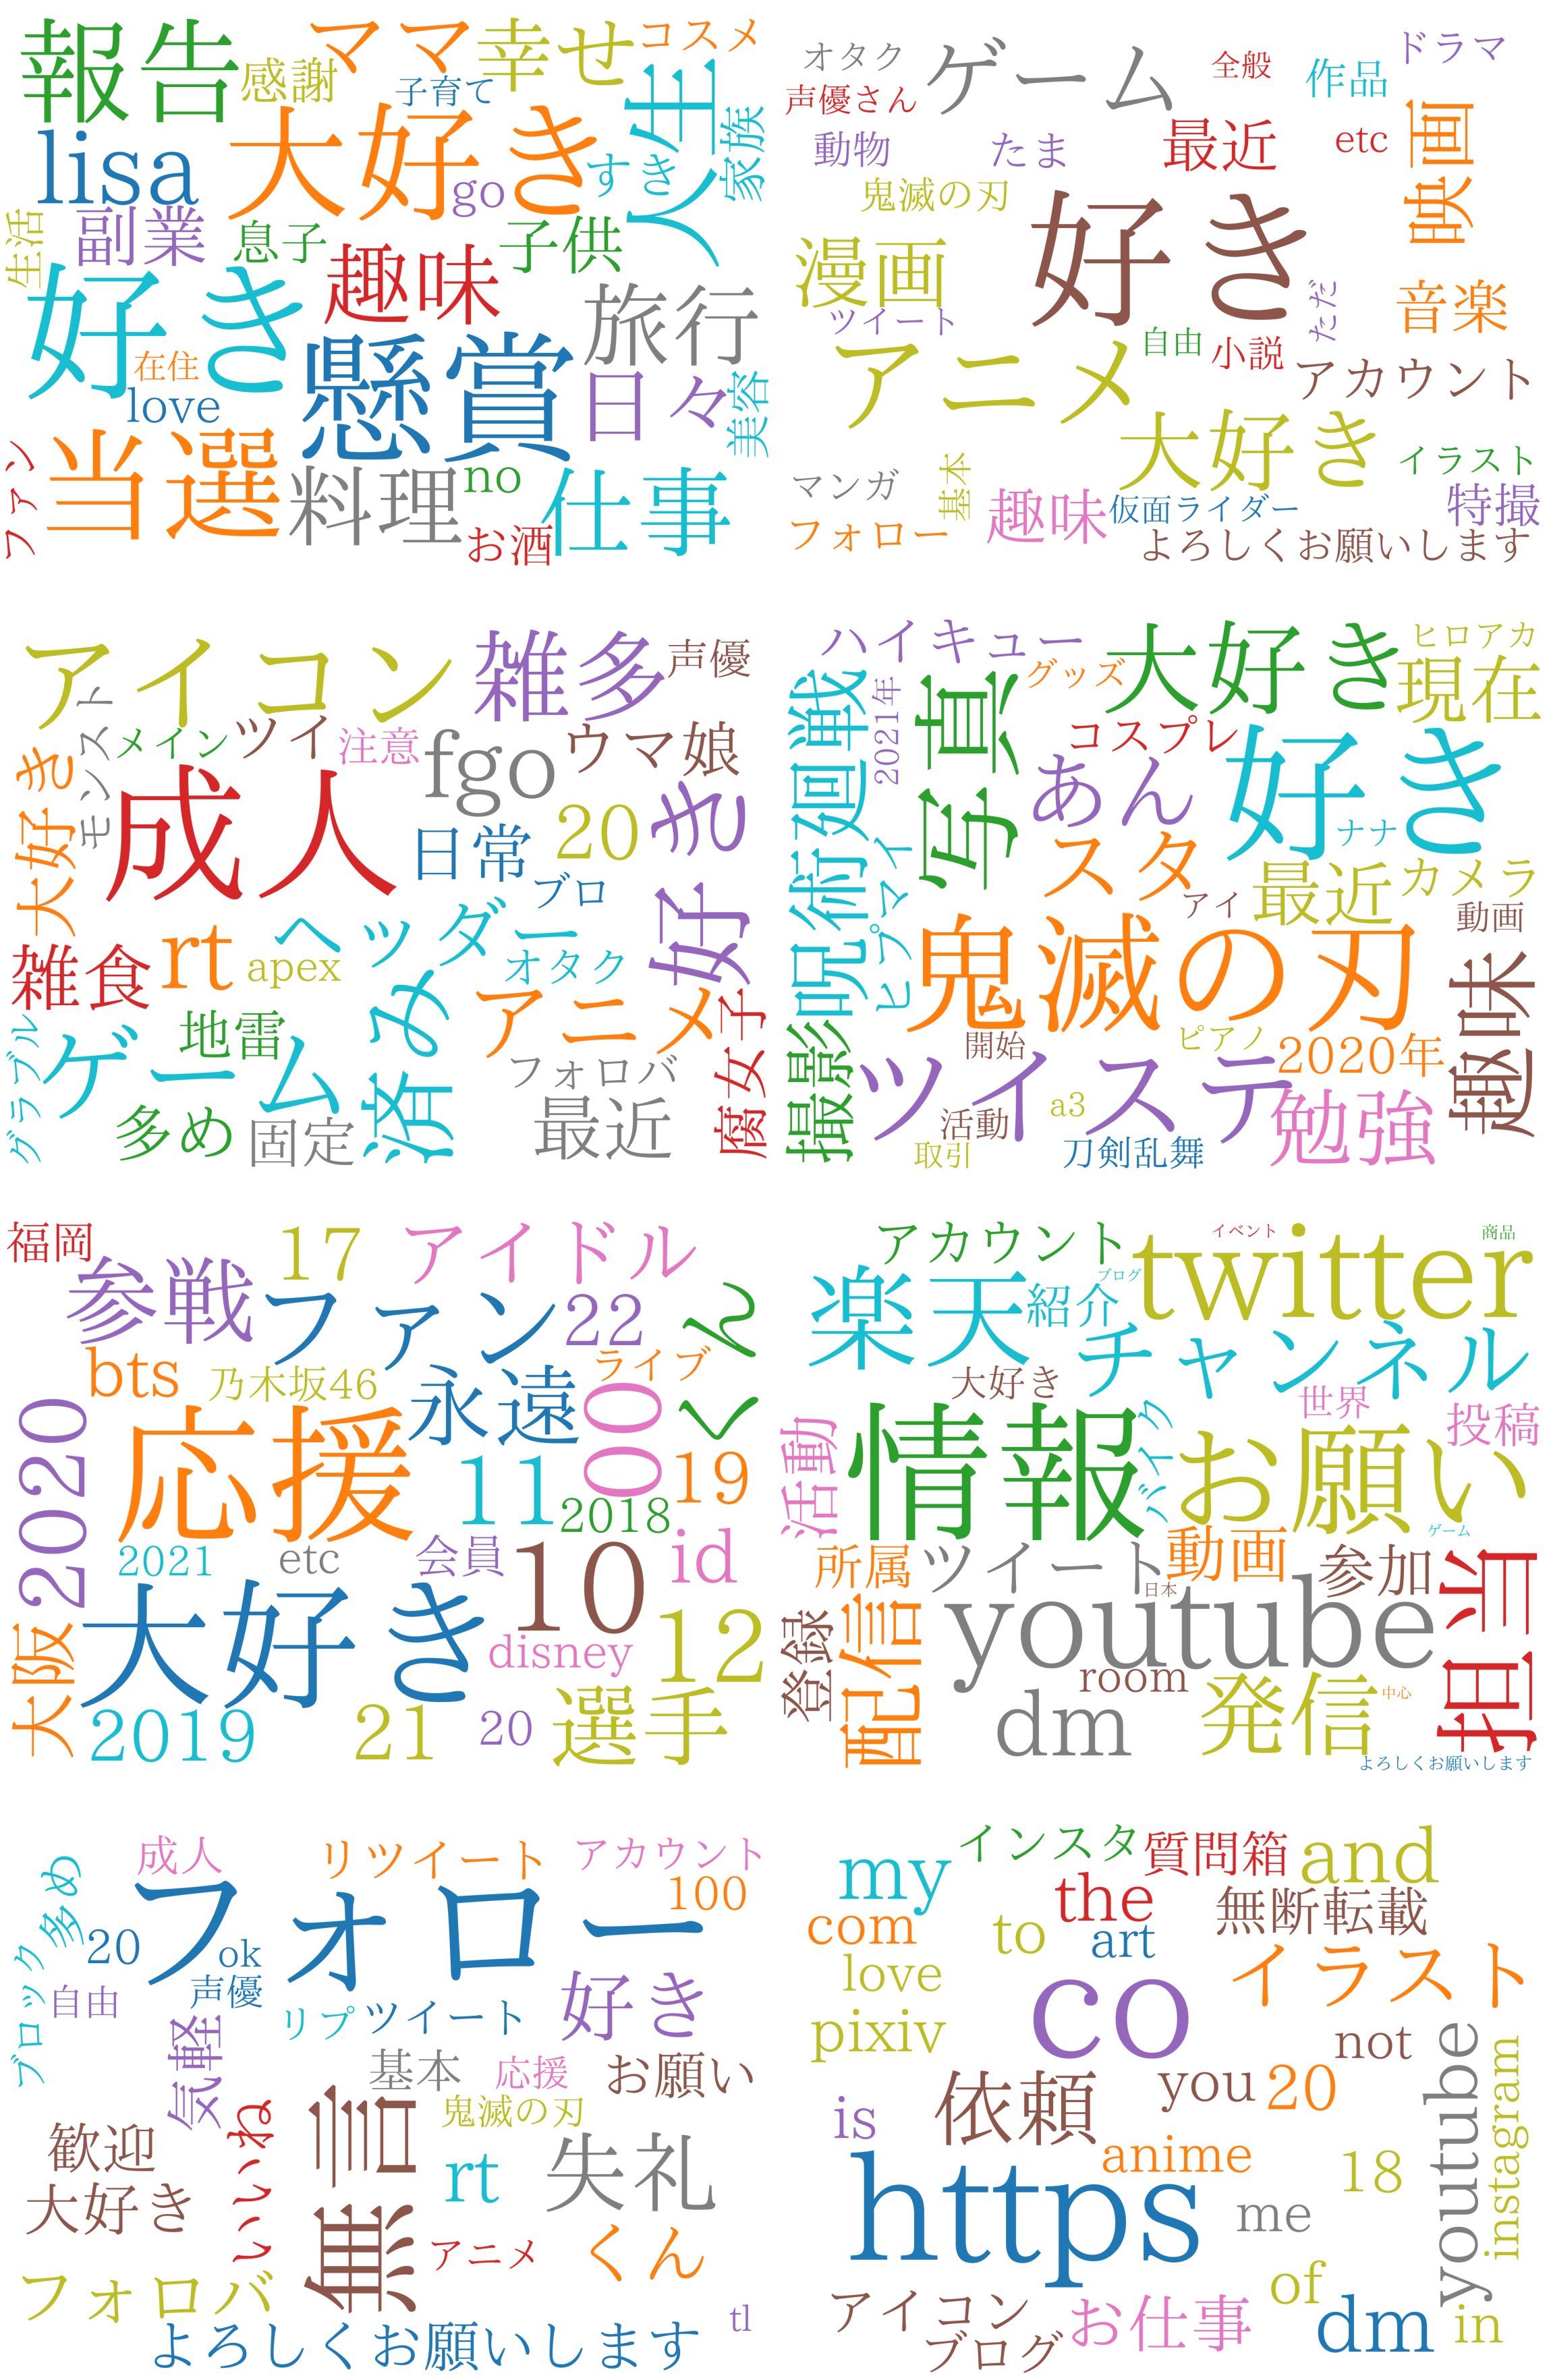

In [59]:
for n_components, topic_word_prior,batch_size in itertools.product([6,7,8,9,10],[0.01, 0.02, 0.05, 0.1, 0.15, 0.2,0.25, 0.3,0.4 ], [500,1000,2000]):

    lda_main(n_components=n_components, topic_word_prior=topic_word_prior, batch_size=batch_size, max_iter=1)
    

### results

In [26]:
tmp_results

{'perplexity': 1675.1924400138482,
 'coherance': [0.7845788096603232,
  0.7667928375409753,
  0.7728259140603563,
  0.7837618505156465,
  0.6802186263545023,
  0.7656973242415142,
  0.7780999695724095,
  0.6691039058680359]}

### プロフィールを

In [ ]:
def get_top_prof (topic_idx, top_n = 100):
    
    topics = lda.transform(X)
    prof_idx_list = topics[:, topic_idx].argsort()[:-top_n - 1:-1]
    return [docs[d] for d in prof_idx_list]

In [ ]:
# get_top_prof(0, 20)

In [ ]:
# get_top_prof(1, 20)

In [ ]:
# get_top_prof(2, 20)

In [ ]:
# get_top_prof(3, 20)

In [ ]:
# get_top_prof(4, 20)

In [ ]:
# get_top_prof(5, 20)

In [ ]:
nownow_file = (datetime.datetime.now() + datetime.timedelta(hours=9) ).strftime('%m%d_%H%M')+"topic_modeling.ipynb"

!cp ./topic_modeling.ipynb ./jupyter_backup_for_param/$nownow_file

In [ ]:
file_name = (datetime.datetime.now() + datetime.timedelta(hours=9) ) .strftime('%m%d_%H%M')+"_output.txt"

6 0.01
6 0.02
6 0.05
6 0.1
6 0.15
6 0.2
7 0.01
7 0.02
7 0.05
7 0.1
7 0.15
7 0.2
8 0.01
8 0.02
8 0.05
8 0.1
8 0.15
8 0.2
9 0.01
9 0.02
9 0.05
9 0.1
9 0.15
9 0.2
10 0.01
10 0.02
10 0.05
10 0.1
10 0.15
10 0.2
